# Pulling + Organizing Data

In [124]:
# Import packages
import numpy as np
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)

## Election Results

In [57]:
# Import data
data1 = pd.read_excel("statistic_id1034688_share-of-electoral-and-popular-votes-by-each-united-states-president-1789-2020 (1).xlsx", sheet_name = "Data")
# Clean the data
results = data1[4:]
results.rename(columns={'Unnamed: 0': 'x1', 'Unnamed: 1':'President', 'Unnamed: 2': 'Electoral College', 'Unnamed: 3': 'Popular Vote', 'Unnamed: 4': 'x2'}, inplace=True)
results.drop(['x1'], axis = 1, inplace = True)
results.drop(['x2'], axis = 1, inplace = True)
results = results.replace('-', np.nan)
# Get the year
results[['President', 'Year']] = results.President.str.split(pat = '(', n = 1, expand = True)
results.Year = results.Year.str[:-1]
# Reverse order
results = results[::-1]
results.reset_index(drop = True, inplace = True)
# Set column types
results = results.astype({'Year': int, 'Electoral College': float, 'Popular Vote': float})
results = results[['Year', 'President', 'Electoral College', 'Popular Vote']]
results.head()

,Year,President,Electoral College,Popular Vote
0,1789,George Washington,100.00,NaN
1,1792,George Washington,100.00,NaN
2,1796,John Adams,51.45,NaN
3,1800,Thomas Jefferson,52.90,NaN
4,1804,Thomas Jefferson,92.05,NaN


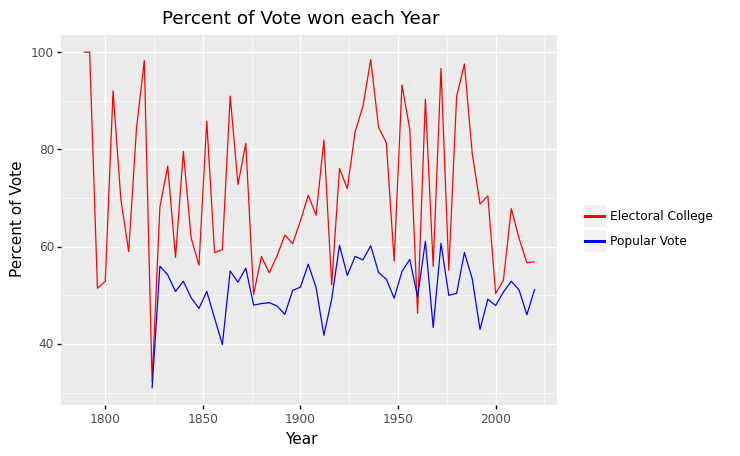

<ggplot: (8761622491522)>

In [58]:
# Visualize the data
(
    ggplot(results, aes(x = "Year")) +
    geom_line(aes(y = "Electoral College", color = '"red"')) + 
    geom_line(aes(y = "Popular Vote", color = "'blue'")) +
    labs(y = "Percent of Vote", title = "Percent of Vote won each Year", color = "") +
    scale_color_manual(values = ("red","blue"), labels = ("Electoral College", 'Popular Vote'))
)

## Previous Presidents

In [59]:
def standardize_party(string):
    if string == "Unaffiliated":
        string = "GW"
    if string == "Federalist":
        string = "F"
    if string == "Democratic-Republican":
        string = "DR"
    if string == "Democratic":
        string = "D"
    if string == "Whig":
        string = "W"
    if string == "Republican":
        string = "R"
    return string

In [60]:
# Pull data
url = "http://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States"
content = pd.read_html(url)
prev_pres = pd.concat(content)
prev_pres = prev_pres[10:92]

# Drop columns
prev_pres.drop(columns =[0, 1, 'Party[b]', 'Politics of the United States', 
                 'Portrait', 'Vice President','vteChief executives of the United States', 
                 'vteChief executives of the United States.1', 
                 'vteLists related to the presidents and vice presidents of the United States', 
                 'vteLists related to the presidents and vice presidents of the United States.1', 
                 'vtePresidents of the United States', 'vtePresidents of the United States.1'], 
               axis = 1, inplace = True)
prev_pres.drop_duplicates(inplace = True)
# Get rid of rows where a President changes party midway through
prev_pres.drop_duplicates(subset = ['Election', 'Name(Birth–Death)'], keep='first', inplace = True)
# Get rid of rows where a President wasn't elected - started in position from assassination of previous
prev_pres.drop_duplicates(subset = ['Election'], keep = 'first', inplace = True)

# Clean column content
prev_pres['Name(Birth–Death)'] = prev_pres['Name(Birth–Death)'].str.split('(').str[0]
prev_pres['Name(Birth–Death)'] = prev_pres['Name(Birth–Death)'].str.split('[').str[0]
prev_pres.rename(columns ={'Election': 'Year', 'Name(Birth–Death)': 'Name', "Party[b].1": 'Party', "Presidency[a]": 'Presidency', 'Presidency[a].1': 'Years in Office'}, inplace = True)
prev_pres.Year[0] = '1789'
prev_pres = prev_pres.astype({'Year': int, 'Presidency': int})

# Change party to be shortened form
prev_pres.Party = prev_pres.Party.apply(standardize_party)
# Fix individual places
prev_pres['Party'][11] = "Adams"
prev_pres['Party'][27] = "R"

In [61]:
prev_pres.head()

,Year,Name,Party,Presidency,Years in Office
0,1789,George Washington,GW,1,"April 30, 1789–March 4, 1797"
1,1792,George Washington,GW,1,"April 30, 1789–March 4, 1797"
2,1796,John Adams,F,2,"March 4, 1797–March 4, 1801"
3,1800,Thomas Jefferson,DR,3,"March 4, 1801–March 4, 1809"
4,1804,Thomas Jefferson,DR,3,"March 4, 1801–March 4, 1809"


## Economic Growth

In [62]:
# Read in data
data2 = pd.read_excel("statistic_id996758_annual-gdp-growth-for-the-united-states-1930-2020 (1).xlsx", sheet_name = "Data")

In [63]:
# Get necessary columns and fix types
gdp = data2[4:]
gdp.reset_index(drop = True, inplace = True)
gdp.drop(columns = ['Unnamed: 0', 'Unnamed: 3'], axis = 1, inplace = True)
gdp.rename(columns = {'Unnamed: 1': "Year", "Unnamed: 2": "Change in GDP in %"}, inplace = True)
gdp = gdp.astype({'Year': int, "Change in GDP in %": float})

# Only look at election years
gdp = gdp[gdp['Year'] % 4 == 0]
gdp.head()

,Year,Change in GDP in %
2,1932,-12.9
6,1936,12.9
10,1940,8.8
14,1944,8.0
18,1948,4.1


## Presidential Ratings

In [64]:
# Pull data
url = "https://www.presidency.ucsb.edu/statistics/data/final-presidential-job-approval-ratings"
content = pd.read_html(url)
ratings = pd.concat(content)

ratings.drop(columns = "Interview Dates", inplace = True)
ratings = ratings.astype({'Year': int, "%Approval": float, "%Disapproval": float, "%No Opinion": float})
ratings.head()

,Year,President,%Approval,%Disapproval,%No Opinion
0,1952,Harry S. Truman,32.0,56.0,12.0
1,1960,Dwight D. Eisenhower,59.0,28.0,13.0
2,1969,Lyndon B. Johnson,49.0,37.0,14.0
3,1974,Richard Nixon,24.0,66.0,10.0
4,1976,Gerald Ford,53.0,32.0,15.0


## State votes

In [65]:
url = 'https://en.wikipedia.org/wiki/List_of_United_States_presidential_election_results_by_state'
content = pd.read_html(url)

states = pd.concat(content)
states.columns = states.iloc[0]
states.drop(states.index[0], inplace = True)

states = states[0: 52]
states = states.iloc[:, 0: 66]
states = states.loc[:, states.columns.notnull()]
states = states.set_index("State")

# Transpose 
states.drop("State", axis = 0, inplace = True)
states = states.transpose()
states.reset_index(inplace = True)
states.rename(columns = {0: "Year"}, inplace = True)
states.Year = states.Year.str[0:4]
states = states.astype({'Year': int})

states = states.merge(prev_pres[['Year', 'Party']], how="left",on= "Year")
states.head()

,Year,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,D.C.,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,Party
0,1789,NaN,NaN,NaN,NaN,NaN,NaN,GW,GW,NaN,...,NaN,NaN,NaN,NaN,GW,NaN,NaN,NaN,NaN,GW
1,1792,NaN,NaN,NaN,NaN,NaN,NaN,GW,GW,NaN,...,NaN,NaN,NaN,GW,GW,NaN,NaN,NaN,NaN,GW
2,1796,NaN,NaN,NaN,NaN,NaN,NaN,F,F,NaN,...,DR,NaN,NaN,F,DR,NaN,NaN,NaN,NaN,F
3,1800,NaN,NaN,NaN,NaN,NaN,NaN,F,F,NaN,...,DR,NaN,NaN,F,DR,NaN,NaN,NaN,NaN,DR
4,1804,NaN,NaN,NaN,NaN,NaN,NaN,F,F,NaN,...,DR,NaN,NaN,DR,DR,NaN,NaN,NaN,NaN,DR


In [66]:
# Create empty list
state_accuracy = list()
for state in range(1, 52):
    # Find number of times a state has voted for the same party as the winning party, divide by number of times a state has voted
    state_accuracy.append([(np.sum(states.iloc[:,state] == states.Party))/states.iloc[:,state].count(), states.columns[state]])
state_accuracy.sort(reverse = True)
state_accuracy[0:7]

[[0.8928571428571429, 'New Mexico'],
 [0.8235294117647058, 'Illinois'],
 [0.8181818181818182, 'Ohio'],
 [0.813953488372093, 'California'],
 [0.8135593220338984, 'Pennsylvania'],
 [0.8103448275862069, 'New York'],
 [0.8, 'Nevada']]

The states that are the most predictive(historically) are New Mexico, Illinois, Ohio, California, Pennsylvania, New York, and Nevada(all 80% accuracy or above). For the purposes of this, we will treat these as the key swing states and add them as dummy variables.

In [67]:
# Create dummy variables for states
state_dummies = states[['Year', 'New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada', 'Party']]

state_dummies['New Mexico'] = 1*(state_dummies['New Mexico'] == state_dummies['Party'])
state_dummies['Illinois'] = 1*(state_dummies['Illinois'] == state_dummies['Party'])
state_dummies['Ohio'] = 1*(state_dummies['Ohio'] == state_dummies['Party'])
state_dummies['California'] = 1*(state_dummies['California'] == state_dummies['Party'])
state_dummies['Pennsylvania'] = 1*(state_dummies['Pennsylvania'] == state_dummies['Party'])
state_dummies['New York'] = 1*(state_dummies['New York'] == state_dummies['Party'])
state_dummies['Nevada'] = 1*(state_dummies['Nevada'] == state_dummies['Party'])
state_dummies.drop(columns = 'Party', inplace = True)
state_dummies.head()

,Year,New Mexico,Illinois,Ohio,California,Pennsylvania,New York,Nevada
0,1789,0,0,0,0,1,0,0
1,1792,0,0,0,0,1,1,0
2,1796,0,0,0,0,0,1,0
3,1800,0,0,0,0,1,1,0
4,1804,0,0,1,0,1,1,0


## Turnout

In [68]:
url = 'https://docs.google.com/spreadsheets/d/1bH38j6_e8yA9xq8OMlyLOL6h_iTS7ABQMKNxzFgKBDo'
content = pd.read_html(url)
data = pd.concat(content)

In [69]:
turnout = data.iloc[:58, 5:7]
turnout.rename(columns = {'A': 'Year', 'B': 'Turnout Rate'}, inplace = True)
turnout.drop(0, axis = 0, inplace = True)
turnout.reset_index(drop = True, inplace = True)
turnout = turnout.astype({'Year': int, 'Turnout Rate': float})
turnout.head()

,Year,Turnout Rate
0,1789,11.6
1,1792,6.3
2,1796,20.1
3,1800,32.3
4,1804,23.8


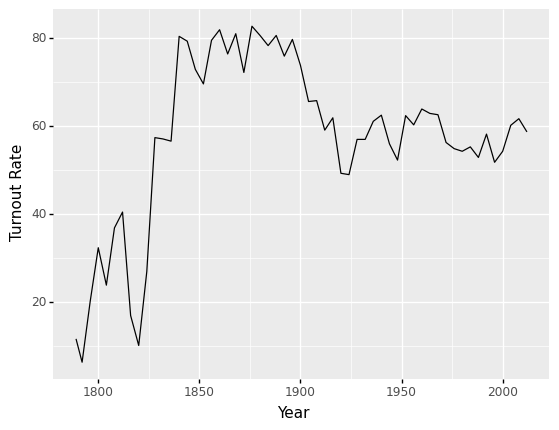

<ggplot: (8761624372474)>

In [70]:
# Visualize the data
(
    ggplot(turnout, aes(x = "Year", y = "Turnout Rate")) +
    geom_line()
)

# Combining Data

In [74]:
# Combine current things - not looking at stats about previous year's presidents
# Election Results, Economic Growth, State Dummies, Turnout, Party - will have to look at Economic Growth separately
results, gdp, state_dummies, turnout
total_data = pd.merge(left = results, right = gdp, how = 'outer',on = "Year")
total_data = pd.merge(left = total_data, right = turnout, how = 'outer', on = 'Year')
total_data = pd.merge(left = total_data, right = prev_pres[['Year', 'Party']], how = 'outer', on = 'Year')
total_data = pd.merge(left = total_data, right = state_dummies, how = 'outer', on = 'Year')

In [122]:
total_data.head()

,Year,President,Electoral College,Popular Vote,Change in GDP in %,Turnout Rate,Party,New Mexico,Illinois,Ohio,California,Pennsylvania,New York,Nevada
0,1789,George Washington,100.00,NaN,NaN,11.6,GW,0,0,0,0,1,0,0
1,1792,George Washington,100.00,NaN,NaN,6.3,GW,0,0,0,0,1,1,0
2,1796,John Adams,51.45,NaN,NaN,20.1,F,0,0,0,0,0,1,0
3,1800,Thomas Jefferson,52.90,NaN,NaN,32.3,DR,0,0,0,0,1,1,0
4,1804,Thomas Jefferson,92.05,NaN,NaN,23.8,DR,0,0,1,0,1,1,0


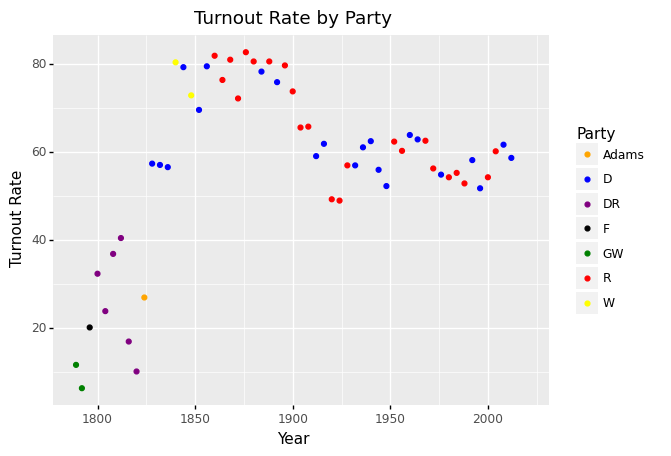

<ggplot: (8761624517283)>

In [88]:
# Turnout Rate each year by Party
(
    ggplot(total_data, aes(x = "Year", y = "Turnout Rate", color = "Party")) +
    geom_point() +
    labs(title = "Turnout Rate by Party") +
    scale_color_manual(values = ("Orange", "Blue", "Purple", "Black", "Green", "Red", "Yellow"))
)

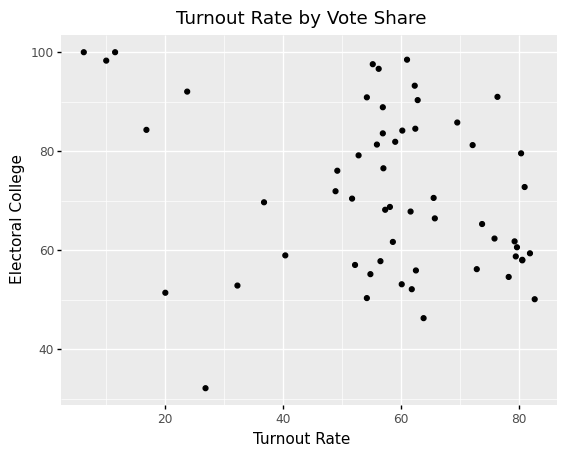

<ggplot: (8761623458136)>

In [142]:
# Turnout Rate by Vote Share
(
    ggplot(total_data, aes(x = "Turnout Rate", y = "Electoral College")) +
    geom_point() +
    labs(title = "Turnout Rate by Vote Share")
)

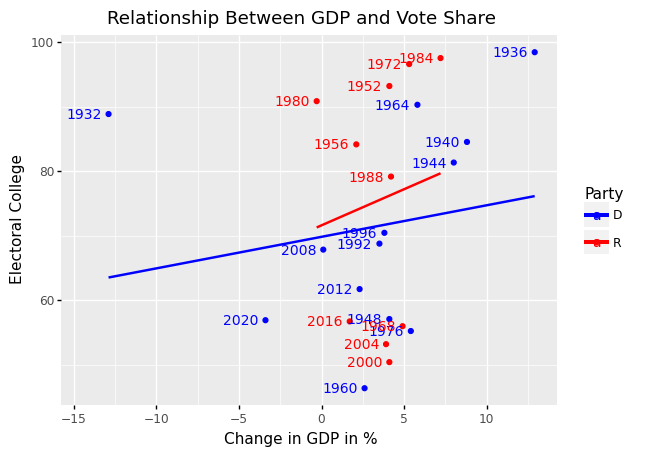

<ggplot: (8761625866436)>

In [144]:
# GDP and Vote Share
(
    ggplot(total_data[35:], aes(x = "Change in GDP in %", y = "Electoral College", color = "Party", label = "Year")) +
    geom_point() +
    geom_text(size = 10, nudge_x = -1.5) +
    labs(title = "Relationship Between GDP and Vote Share") +
    scale_color_manual(values = ("Blue", "Red")) +
    geom_smooth(method = 'lm', se = False)
)

In [128]:
len(total_data.Year)

59

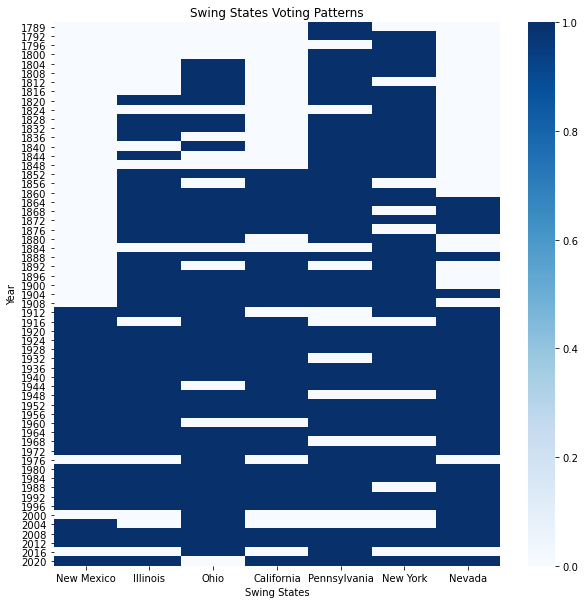

In [133]:
# Heatmap for Swing STates
# Create a figure 
plt.figure(figsize = (10,10))

# Create a heatmap
plot = sns.heatmap(total_data[['New Mexico', 'Illinois', 'Ohio', 'California', 'Pennsylvania', 'New York', 'Nevada']],
                  yticklabels= total_data.Year, cmap = "Blues")
ax = plt.gca()
ax.set_yticklabels(total_data.Year)

#Label x and y axes
plt.xlabel('Swing States')
plt.ylabel('Year')

#Add a title
plt.title('Swing States Voting Patterns')

plt.show()